In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
from scipy.stats import chi2_contingency
import os

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [ ]:
abs_path = os.path.abspath('')
data_path = os.path.join(abs_path, 'data')

In [ ]:
class Analyzer:
    def __init__(self):
        self.A = None
        self.B = None
        self.paired = None
        self.testtype = None
        self.result = None

        # THEME (defaults)
        self.font_family   = "DejaVu Sans"   # e.g., "Arial"
        self.figsize_main  = (16, 10)
        self.figsize_small = (14, 6)
        self.dpi           = 110

        # colors & palettes
        self.color_A   = "#00FFFF"   # group A
        self.color_B   = "#FF00FF"   # group B
        self.color_box = "#9370DB"   # single boxplot fill
        self.color_hist= "#3CB371"   # single histogram fill
        self.cmap_seq  = "mako"      # sequential heatmap
        self.cmap_hex  = "rocket"    # hexbin
        self.cmap_bar  = "magma"     # bar plots palette

        # global style
        import seaborn as sns, matplotlib as mpl
        sns.set_theme(style="dark", context="talk")  # dark style as base
        mpl.rcParams["font.family"]      = self.font_family
        mpl.rcParams["figure.dpi"]       = self.dpi
        mpl.rcParams["axes.titleweight"] = "bold"

        # custom background + cyan elements
        mpl.rcParams["axes.facecolor"]   = "#0A0A0A"  # very dark gray (not full black)
        mpl.rcParams["figure.facecolor"] = "#0A0A0A"  # same as axes background

        # grid + lines in cyan
        mpl.rcParams["grid.color"]       = "#00FFFF"  # cyan grid
        mpl.rcParams["grid.alpha"]       = 0.8
        mpl.rcParams["axes.edgecolor"]   = "#00FFFF"
        mpl.rcParams["xtick.color"]      = "#00FFFF"
        mpl.rcParams["ytick.color"]      = "#00FFFF"

        # text in cyan
        mpl.rcParams["text.color"]       = "#00FFFF"
        mpl.rcParams["axes.labelcolor"]  = "#00FFFF"
        mpl.rcParams["axes.titlecolor"]  = "#00FFFF"

        # lines/legend in cyan
        mpl.rcParams["lines.color"]      = "#00FFFF"
        mpl.rcParams["legend.edgecolor"] = "#00FFFF"
        mpl.rcParams["legend.labelcolor"]= "#00FFFF"
        mpl.rcParams["legend.facecolor"] = "#0A0A0A"





    # Optional: change theme on the fly
    def set_theme(self, *,
                  color_A=None, color_B=None, color_box=None, color_hist=None,
                  cmap_seq=None, cmap_hex=None, cmap_bar=None,
                  style="whitegrid", context="talk",
                  font_family=None, dpi=None,
                  figsize_main=None, figsize_small=None):
        import seaborn as sns, matplotlib as mpl
        if color_A   is not None: self.color_A   = color_A
        if color_B   is not None: self.color_B   = color_B
        if color_box is not None: self.color_box = color_box
        if color_hist is not None: self.color_hist= color_hist
        if cmap_seq  is not None: self.cmap_seq  = cmap_seq
        if cmap_hex  is not None: self.cmap_hex  = cmap_hex
        if cmap_bar  is not None: self.cmap_bar  = cmap_bar
        if font_family is not None:
            self.font_family = font_family
            mpl.rcParams["font.family"] = font_family
        if dpi is not None:
            self.dpi = dpi
            mpl.rcParams["figure.dpi"] = dpi
        if figsize_main  is not None: self.figsize_main  = figsize_main
        if figsize_small is not None: self.figsize_small = figsize_small
        sns.set_theme(style=style, context=context)
        return self

    def format_prepare(self, data, column=None):
        """
        Ensure data is a 1D numeric array (if DataFrame, pick column).
        """
        if isinstance(data, np.ndarray):
            if data.ndim > 1:
                return data.flatten()
            return data
        elif isinstance(data, pd.Series):
            return data.values
        elif isinstance(data, pd.DataFrame):
            if column is None:
                if data.shape[1] == 1:
                    return data.iloc[:, 0].values
                else:
                    raise ValueError("DataFrame has multiple columns. Please specify 'column'.")
            else:
                if column not in data.columns:
                    raise ValueError(f"Column '{column}' not found in DataFrame.")
                return data[column].values
        elif isinstance(data, list):
            return np.array(data)
        else:
            raise TypeError("Unsupported data type. Use list, numpy array, pandas Series, or DataFrame.")

    def fit(self, a, b, column_a=None, column_b=None, paired=False):
        """
        Prepare arrays and (only if paired) enforce equal lengths.
        """
        format_checked_a = self.format_prepare(a, column_a)
        format_checked_b = self.format_prepare(b, column_b)

        if paired and (len(format_checked_a) != len(format_checked_b)):
            raise ValueError("For paired data, x and y must have the same length.")

        self.A = format_checked_a
        self.B = format_checked_b
        self.paired = paired

    def summary_check(self):
        return {
            "x_shape": self.A.shape,
            "y_shape": self.B.shape,
            "x_dtype": self.A.dtype,
            "y_dtype": self.B.dtype,
            "paired": self.paired,
            "test type": self.testtype
        }

    def _check_normality(self, data):
        """Check normality using Shapiro-Wilk test (p>0.05 = normal)."""
        stat, p = stats.shapiro(data)
        return p > 0.05

    def analysis_starter(self, alpha: float = 0.05):
        """
        Choose test based on pairedness, normality, and variance homogeneity.
        Sets self.testtype and returns it.
        """
        if self.A is None or self.B is None:
            raise Exception("A and B are empty. You must specify data group a and b with fit(a, b, ...).")

        A = np.asarray(self.A, dtype=float)
        B = np.asarray(self.B, dtype=float)

        if self.paired and (len(A) != len(B)):
            raise ValueError("Paired analysis requires A and B to have equal length.")

        def shapiro_p(x):
            x = x[~np.isnan(x)]
            return stats.shapiro(x).pvalue if len(x) >= 3 else np.nan

        if self.paired:
            D = A - B
            p_diff = shapiro_p(D)
            is_normal = (p_diff > alpha) if not np.isnan(p_diff) else False
            self.testtype = "Paired t-test" if is_normal else "Wilcoxon Signed-Rank Test"
        else:
            p_a = shapiro_p(A)
            p_b = shapiro_p(B)
            both_normal = ((p_a > alpha) if not np.isnan(p_a) else False) and \
                          ((p_b > alpha) if not np.isnan(p_b) else False)
            if both_normal:
                p_levene = stats.levene(A, B, center='median').pvalue
                equal_var = p_levene > alpha
                self.testtype = "Independent t-test (equal var)" if equal_var else "Welch t-test"
            else:
                self.testtype = "Mann-Whitney U Test"
        return self.testtype

    def run_test(self, alpha: float = 0.05):
        """
        Execute the selected test and store a result dict in self.result.
        """
        if self.A is None or self.B is None:
            raise Exception("A and B are empty. Call fit(a, b, ...) first.")
        if self.testtype is None:
            raise ValueError("Please run analysis_starter() first to determine the test type.")

        A = np.asarray(self.A, dtype=float)
        B = np.asarray(self.B, dtype=float)

        if self.testtype in ("Paired t-test", "Wilcoxon Signed-Rank Test") and (len(A) != len(B)):
            raise ValueError("Paired test selected but A and B lengths differ.")

        t = self.testtype
        res = {"test_used": t, "alpha": alpha, "n_a": int(len(A)), "n_b": int(len(B))}

        if t == "Independent t-test (equal var)":
            stat_v, p = stats.ttest_ind(A, B, equal_var=True)
            eff = self._cohen_d_independent(A, B, equal_var=True)
        elif t == "Welch t-test":
            stat_v, p = stats.ttest_ind(A, B, equal_var=False)
            eff = self._cohen_d_independent(A, B, equal_var=False)
        elif t == "Paired t-test":
            stat_v, p = stats.ttest_rel(A, B)
            eff = self._cohen_d_paired(A, B)
        elif t == "Mann-Whitney U Test":
            stat_v, p = stats.mannwhitneyu(A, B, alternative="two-sided")
            eff = self._rank_biserial_from_mwu(A, B, stat_v)
        elif t == "Wilcoxon Signed-Rank Test":
            stat_v, p = stats.wilcoxon(A, B, zero_method="wilcox", correction=False, alternative="two-sided", mode="auto")
            eff = self._rank_biserial_from_wilcoxon(A, B, stat_v)
        elif t == "Pearson Correlation":
            stat_v, p = stats.pearsonr(A, B)
            eff = stat_v
        elif t == "Spearman Correlation":
            stat_v, p = stats.spearmanr(A, B)
            eff = stat_v
        else:
            raise ValueError(f"Unsupported test type: {t}")

        res.update({
            "statistic": float(stat_v),
            "p_value": float(p),
            "significant": bool(p < alpha),
            "effect_size": float(eff) if eff is not None else None,
        })
        self.result = res
        return res

    # ---------- DataFrame access helpers ----------
    def set_df(self, df: pd.DataFrame):
        """Attach a working DataFrame to the Analyzer instance."""
        if not isinstance(df, pd.DataFrame):
            raise TypeError("set_df expects a pandas DataFrame.")
        self.df = df.copy()
        return self

    def _ensure_df(self):
        if not hasattr(self, "df") or self.df is None:
            raise AttributeError("No DataFrame set. Call set_df(df) first.")

    def _get_series(self, col: str, dropna: bool = True) -> pd.Series:
        self._ensure_df()
        if col not in self.df.columns:
            raise KeyError(f"Column '{col}' not found in the DataFrame.")
        s = self.df[col]
        if dropna:
            s = s.dropna()
        return s

    def _is_categorical(self, s: pd.Series) -> bool:
        """Heuristic: non-numeric or numeric with few uniques behaves as categorical."""
        if not pd.api.types.is_numeric_dtype(s):
            return True
        nun = s.nunique(dropna=True)
        return (nun <= 20) or (nun / max(len(s), 1) < 0.05)

    # ---------- Interpretation & compact report ----------
    def _basic_group_stats(self) -> dict:
        if self.A is None or self.B is None:
            raise Exception("A and/or B are empty. Call fit(a, b, ...) first.")
        a = np.asarray(self.A, dtype=float); a = a[~np.isnan(a)]
        b = np.asarray(self.B, dtype=float); b = b[~np.isnan(b)]
        stats_a = {
            "n": int(len(a)),
            "mean": float(np.nanmean(a)) if len(a) else np.nan,
            "std": float(np.nanstd(a, ddof=1)) if len(a) > 1 else np.nan,
            "median": float(np.nanmedian(a)) if len(a) else np.nan,
        }
        stats_b = {
            "n": int(len(b)),
            "mean": float(np.nanmean(b)) if len(b) else np.nan,
            "std": float(np.nanstd(b, ddof=1)) if len(b) > 1 else np.nan,
            "median": float(np.nanmedian(b)) if len(b) else np.nan,
        }
        return {"A": stats_a, "B": stats_b}

    def _effect_size_label(self, value: float) -> str:
        if value is None or np.isnan(value):
            return "unknown"
        v = abs(value)
        if v >= 0.8: return "large"
        if v >= 0.5: return "medium"
        if v >= 0.2: return "small"
        return "very small"

    def interpret(self, alpha: float = 0.05, verbose: bool = True):
        if self.result is None:
            self.run_test(alpha=alpha)

        res = dict(self.result)
        groups = self._basic_group_stats()
        res["group_stats"] = groups

        test_name = res.get("test_used", "unknown test")
        stat_v    = res.get("statistic", np.nan)
        p         = res.get("p_value", np.nan)
        eff       = res.get("effect_size", None)
        sig       = res.get("significant", False)

        a_mean, b_mean = groups["A"]["mean"], groups["B"]["mean"]
        a_med,  b_med  = groups["A"]["median"], groups["B"]["median"]
        if isinstance(test_name, str) and any(k in test_name.lower() for k in ["mann", "wilcoxon"]):
            diff = float(a_med - b_med); diff_label = "median(A) - median(B)"
        else:
            diff = float(a_mean - b_mean); diff_label = "mean(A) - mean(B)"

        res["difference"]   = {"name": diff_label, "value": diff}
        res["effect_label"] = self._effect_size_label(eff)

        if verbose:
            print("=" * 60)
            print(f"Test: {test_name} | alpha={alpha}")
            print(f"Statistic={stat_v:.4f} | p-value={p:.4g} | significant={sig}")
            if eff is not None:
                print(f"Effect size={eff:.3f} ({res['effect_label']})")
            print(f"{diff_label} = {diff:.4f}")
            print(f"A: n={groups['A']['n']}, mean={groups['A']['mean']:.4f}, median={groups['A']['median']:.4f}, std={groups['A']['std']}")
            print(f"B: n={groups['B']['n']}, mean={groups['B']['mean']:.4f}, median={groups['B']['median']:.4f}, std={groups['B']['std']}")
            print("=" * 60)
        return res

    def quick_report(self, alpha: float = 0.05) -> dict:
        if self.result is None or self.testtype is None:
            self.analysis_starter(alpha=alpha)
            self.run_test(alpha=alpha)

        groups = self._basic_group_stats()
        out = dict(self.result)
        out["group_stats"] = groups

        test_name = out.get("test_used", "")
        if isinstance(test_name, str) and any(k in test_name.lower() for k in ["mann", "wilcoxon"]):
            diff_name = "median(A)-median(B)"
            diff_val  = float(groups["A"]["median"] - groups["B"]["median"])
        else:
            diff_name = "mean(A)-mean(B)"
            diff_val  = float(groups["A"]["mean"] - groups["B"]["mean"])
        out["difference"]   = {"name": diff_name, "value": diff_val}
        out["effect_label"] = self._effect_size_label(out.get("effect_size", None))
        return out

    # ---------- Univariate ----------
    def describe_numeric(self, col: str, bins: int = 10, kde: bool = True, alpha: float = 0.05):
        s = self._get_series(col, dropna=True).astype(float)

        desc      = s.describe()
        shapiro_p = stats.shapiro(s).pvalue if len(s) >= 3 else np.nan
        is_normal = (shapiro_p > alpha) if not np.isnan(shapiro_p) else False
        skew_val  = stats.skew(s)
        q1, q3    = s.quantile(0.25), s.quantile(0.75)
        iqr       = q3 - q1
        lower_b, upper_b = q1 - 1.5*iqr, q3 + 1.5*iqr
        n_low = int((s < lower_b).sum()); n_high = int((s > upper_b).sum())
        n_out = n_low + n_high
        pct_out = 100.0 * n_out / len(s) if len(s) else 0.0
        missing = int(self.df[col].isna().sum())

        fig, ax = plt.subplots(2, 2, figsize=self.figsize_small, gridspec_kw={'height_ratios': (.85, .15)})

        # Histogram
        sns.histplot(s, kde=kde, ax=ax[0, 0], color=self.color_hist)
        ax[0, 0].set_title(f'Histogram of {col}')
        ax[0, 0].set_xlabel(''); ax[0, 0].set_ylabel('Count')

        # Boxplot
        sns.boxplot(x=s, ax=ax[1, 0], color=self.color_box, orient='h')
        import matplotlib.patches as mpatches
        label_text = f"Lower outliers: {n_low}\nUpper outliers: {n_high}\nTotal: {n_out} ({pct_out:.1f}%)"
        patch = mpatches.Patch(color='lightsteelblue', label=label_text)
        ax[1, 0].legend(handles=[patch], fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1))

        # PDF/CDF
        counts, bin_edges = np.histogram(s, bins=bins, density=True)
        pdf = counts / counts.sum() if counts.sum() != 0 else counts
        cdf = np.cumsum(pdf)
        ax[1, 1] = plt.subplot(122)
        plt.plot(bin_edges[1:], pdf, label='PDF', linewidth=2, color=self.color_A)
        plt.plot(bin_edges[1:], cdf, label='CDF', linewidth=2, color=self.color_B)
        plt.legend(); plt.xticks(rotation=45)

        ax[0, 0].set_xticklabels([]); ax[1, 0].set_yticklabels([])
        fig.suptitle(col, fontsize=18)
        plt.tight_layout(); plt.show()

        return {
            "count": int(desc.get("count", 0)),
            "mean": float(desc.get("mean", np.nan)),
            "std": float(desc.get("std", np.nan)),
            "min": float(desc.get("min", np.nan)),
            "25%": float(desc.get("25%", np.nan)),
            "50%": float(desc.get("50%", np.nan)),
            "75%": float(desc.get("75%", np.nan)),
            "max": float(desc.get("max", np.nan)),
            "missing": missing,
            "shapiro_p": float(shapiro_p) if not np.isnan(shapiro_p) else None,
            "normal": bool(is_normal),
            "skew": float(skew_val),
            "iqr_lower_bound": float(lower_b),
            "iqr_upper_bound": float(upper_b),
            "outliers_lower": n_low,
            "outliers_upper": n_high,
            "outliers_total_pct": round(pct_out, 2)
        }

    def describe_categorical(self, col: str, top_n: int = None):
        s = self._get_series(col, dropna=False)
        counts = s.value_counts(dropna=True)
        if top_n is not None and top_n > 0:
            counts = counts.head(top_n)
        total_non_na = counts.sum()
        perc = (counts / total_non_na * 100.0).round(2) if total_non_na else counts

        plt.figure(figsize=self.figsize_small)
        sns.barplot(x=counts.index.astype(str), y=counts.values, color=self.color_hist)
        plt.title(f'Counts of {col}')
        plt.ylabel('Count'); plt.xlabel(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout(); plt.show()

        return {
            "missing": int(s.isna().sum()),
            "unique": int(s.nunique(dropna=True)),
            "counts": counts.to_dict(),
            "percents": perc.to_dict()
        }

    def bin_numeric(self, col: str, bins, labels=None, new_col: str = None,
                    right: bool = True, include_lowest: bool = True):
        self._ensure_df()
        if new_col is None:
            new_col = f"{col}_binned"
        s = self._get_series(col, dropna=False)
        binned = pd.cut(s, bins=bins, labels=labels, right=right, include_lowest=include_lowest)
        self.df[new_col] = binned
        return self.df[new_col]

    # ---------- Bivariate ----------
    def rel(self, feature: str, target: str, alpha: float = 0.05):
        x = self._get_series(feature, dropna=False)
        y = self._get_series(target, dropna=False)
        x_is_cat = self._is_categorical(x)
        y_is_cat = self._is_categorical(y)
        if not x_is_cat and not y_is_cat:
            return self.rel_num_num(feature, target, alpha=alpha)
        elif x_is_cat and y_is_cat:
            return self.rel_cat_cat(feature, target, alpha=alpha)
        else:
            if x_is_cat and not y_is_cat:
                return self.rel_cat_num(cat_col=feature, num_col=target, alpha=alpha)
            else:
                return self.rel_cat_num(cat_col=target, num_col=feature, alpha=alpha)

    def rel_num_num(self, col1: str, col2: str, alpha: float = 0.05, gridsize: int = 20):
        s1 = self._get_series(col1, dropna=True).astype(float)
        s2 = self._get_series(col2, dropna=True).astype(float)
        df_pair = pd.DataFrame({col1: s1, col2: s2}).dropna()
        x = df_pair[col1].values
        y = df_pair[col2].values

        sh1 = stats.shapiro(x).pvalue if len(x) >= 3 else np.nan
        sh2 = stats.shapiro(y).pvalue if len(y) >= 3 else np.nan
        both_normal = (sh1 > alpha if not np.isnan(sh1) else False) and (sh2 > alpha if not np.isnan(sh2) else False)

        if both_normal:
            test_used = "Pearson"
            r, p = stats.pearsonr(x, y)
        else:
            test_used = "Spearman"
            r, p = stats.spearmanr(x, y)

        r2 = r ** 2
        strength  = "strong" if abs(r) > 0.7 else ("moderate" if abs(r) > 0.3 else "weak")
        direction = "positive" if r > 0 else "negative"

        fig, axes = plt.subplots(1, 2, figsize=self.figsize_small)
        fig.suptitle(f'{col1} vs {col2} - {test_used} correlation', fontsize=14)

        # Scatter
        axes[0].scatter(x, y, s=50, alpha=0.7, color=self.color_A, edgecolors='black', linewidth=0.4)
        axes[0].set_title('Scatter')
        axes[0].set_xlabel(col1); axes[0].set_ylabel(col2); axes[0].grid(True, alpha=0.3)

        # Hexbin
        hb = axes[1].hexbin(x, y, gridsize=gridsize, cmap=self.cmap_hex, mincnt=1)
        axes[1].set_title('Hexbin'); axes[1].set_xlabel(col1); axes[1].set_ylabel(col2)
        cb = fig.colorbar(hb, ax=axes[1]); cb.set_label('count')

        plt.tight_layout(); plt.show()

        return {
            "test_used": test_used,
            "shapiro_p_col1": float(sh1) if not np.isnan(sh1) else None,
            "shapiro_p_col2": float(sh2) if not np.isnan(sh2) else None,
            "correlation": float(r),
            "r_squared": float(r2),
            "p_value": float(p),
            "significant": bool(p < alpha),
            "relationship_strength": strength,
            "relationship_direction": direction,
            "n": int(len(x))
        }

    def rel_cat_num(self, cat_col: str, num_col: str, alpha: float = 0.05):
        s_cat = self._get_series(cat_col, dropna=False)
        s_num = self._get_series(num_col, dropna=True).astype(float)

        df_local = pd.DataFrame({cat_col: s_cat, num_col: self.df[num_col]}).dropna()
        groups = df_local.groupby(cat_col)[num_col].describe()
        normality = {}; data_groups = []; all_normal = True

        for name, grp in df_local.groupby(cat_col):
            vals = grp[num_col].values
            if len(vals) >= 3:
                p_sh = stats.shapiro(vals).pvalue
                is_norm = p_sh > alpha
                normality[name] = {"shapiro_p": float(p_sh), "is_normal": bool(is_norm), "n": int(len(vals))}
                if not is_norm: all_normal = False
            else:
                normality[name] = {"shapiro_p": None, "is_normal": False, "n": int(len(vals))}
                all_normal = False
            data_groups.append(vals)

        test_used = None; stat_v, p_val = np.nan, np.nan
        if len(data_groups) >= 2:
            if all_normal:
                test_used = "ANOVA"
                stat_v, p_val = stats.f_oneway(*data_groups)
            else:
                try:
                    from scipy.stats import alexandergovern
                    result = alexandergovern(*data_groups)
                    stat_v, p_val = float(result.statistic), float(result.pvalue)
                    test_used = "Welch_ANOVA"
                except Exception:
                    stat_v, p_val = stats.kruskal(*data_groups)
                    test_used = "Kruskal_Wallis"
        else:
            test_used = "insufficient_groups"

        fig = plt.figure(figsize=self.figsize_main)

        ax1 = plt.subplot(221)
        sns.boxplot(data=df_local, x=cat_col, y=num_col, ax=ax1, palette=self.cmap_bar)
        ax1.set_title(f'{num_col} by {cat_col}'); plt.xticks(rotation=45)

        ax2 = plt.subplot(222)
        sns.violinplot(data=df_local, x=cat_col, y=num_col, ax=ax2, palette=self.cmap_bar)
        ax2.set_title(f'{num_col} distribution by {cat_col}'); plt.xticks(rotation=45)

        ax3 = plt.subplot(223)
        means = df_local.groupby(cat_col)[num_col].mean().sort_values(ascending=False)
        sns.barplot(x=means.index, y=means.values, ax=ax3, palette=self.cmap_bar)
        ax3.set_title(f'Mean {num_col} by {cat_col}'); plt.xticks(rotation=45)

        ax4 = plt.subplot(224)
        sns.countplot(data=df_local, x=cat_col, ax=ax4, palette=self.cmap_bar)
        ax4.set_title(f'Count of {cat_col}'); plt.xticks(rotation=45)

        plt.tight_layout(); plt.show()

        return {
            "test_used": test_used,
            "all_groups_normal": bool(all_normal),
            "statistic": float(stat_v) if not np.isnan(stat_v) else None,
            "p_value": float(p_val) if not np.isnan(p_val) else None,
            "significant": (p_val < alpha) if not np.isnan(p_val) else None,
            "num_categories": int(df_local[cat_col].nunique()),
            "total_observations": int(len(df_local)),
            "group_stats": groups.to_dict(),
            "normality": normality
        }

    def rel_cat_cat(self, col1: str, col2: str, alpha: float = 0.05):
        s1 = self._get_series(col1, dropna=False).astype("category")
        s2 = self._get_series(col2, dropna=False).astype("category")

        df_local = pd.DataFrame({col1: s1, col2: s2}).dropna()
        table = pd.crosstab(df_local[col1], df_local[col2])
        norm  = pd.crosstab(df_local[col1], df_local[col2], normalize='index')
        n = table.values.sum()

        chi2, p_val, dof, expected = stats.chi2_contingency(table)
        too_small = (expected < 5).sum()
        expected_ok = (too_small / expected.size) <= 0.2

        k = min(table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * max(k, 1)))
        strength = "strong" if cramers_v > 0.3 else ("moderate" if cramers_v > 0.1 else "weak")

        fig, axs = plt.subplots(2, 2, figsize=self.figsize_main)

        sns.heatmap(table, annot=True, fmt='d', cbar=False, cmap=self.cmap_seq,
                    ax=axs[0, 0], linecolor='lightgray', linewidths=0.7)
        axs[0, 0].set_title(f'Contingency: {col1} vs {col2}')

        norm.plot.bar(stacked=True, ax=axs[0, 1], colormap=self.cmap_bar)
        axs[0, 1].set_title('Stacked Bar (100%)')
        axs[0, 1].legend(title=col2)
        axs[0, 1].set_xlabel(col1); axs[0, 1].set_ylabel('Proportion')

        sns.heatmap(norm, annot=True, fmt='.2%', cbar=False, cmap=self.cmap_seq,
                    ax=axs[1, 0], linecolor='lightgray', linewidths=0.7)
        axs[1, 0].set_title('Row-normalized (%)')

        table.plot(kind='bar', ax=axs[1, 1], colormap=self.cmap_bar)
        axs[1, 1].set_title('Counts by group'); axs[1, 1].legend(title=col2)
        plt.xticks(rotation=45)

        plt.tight_layout(); plt.show()

        return {
            "chi2_statistic": float(chi2),
            "p_value": float(p_val),
            "degrees_of_freedom": int(dof),
            "cramers_v": float(cramers_v),
            "association_strength": strength,
            "significant_association": bool(p_val < alpha),
            "expected_counts_ok": bool(expected_ok),
            "contingency_table": table.to_dict(),
            "normalized_row": norm.to_dict(),
            "n": int(n)
        }

    # ---------- KPI helpers & plots ----------
    def _get_grouped_data(self, group_cols, kpi: str = "Conversion Rate"):
        self._ensure_df()
        if isinstance(group_cols, (str,)):
            group_cols = [group_cols]

        df = self.df.copy()
        if kpi not in df.columns:
            if kpi == "Conversion Rate":
                if all(c in df.columns for c in ["conversions", "clicks"]):
                    df["Conversion Rate"] = np.where(df["clicks"] > 0,
                                                     (df["conversions"] / df["clicks"]) * 100.0, np.nan)
                else:
                    raise KeyError("To compute 'Conversion Rate', columns 'conversions' and 'clicks' must exist.")
            elif kpi == "CPC":
                if all(c in df.columns for c in ["cost", "clicks"]):
                    df["CPC"] = np.where(df["clicks"] > 0, df["cost"] / df["clicks"], np.nan)
                else:
                    raise KeyError("To compute 'CPC', columns 'cost' and 'clicks' must exist.")
            else:
                raise ValueError("KPI must be either 'Conversion Rate' or 'CPC'.")

        grouped = df.groupby(group_cols, dropna=False, as_index=False)[kpi].mean()
        return grouped

    def kpi_heatmap(self, group1: str, group2: str, kpi: str = "Conversion Rate"):
        if kpi not in ["Conversion Rate", "CPC"]:
            raise ValueError('KPI must be "Conversion Rate" or "CPC"')

        tmp = self._get_grouped_data([group1, group2], kpi=kpi)
        heatmap_data = tmp.pivot_table(index=group1, columns=group2, values=kpi).fillna(0)

        plt.figure(figsize=self.figsize_main)
        sns.heatmap(
            heatmap_data,
            cmap=self.cmap_seq,
            annot=True,
            linewidths=0.7,
            linecolor='white'
        )
        plt.title(f'Heatmap of {kpi} by {group1} / {group2}', fontsize=18, weight='bold')
        plt.ylabel(group1); plt.xlabel(group2)
        plt.tight_layout(); plt.show()
        return heatmap_data

    def kpi_bar(self, group_col: str, kpi: str = "Conversion Rate"):
        if kpi not in ["Conversion Rate", "CPC"]:
            raise ValueError('KPI must be "Conversion Rate" or "CPC"')

        tmp = self._get_grouped_data(group_col, kpi=kpi)

        plt.figure(figsize=self.figsize_small)
        ax = sns.barplot(data=tmp, x=group_col, y=kpi, palette=self.cmap_bar)
        ax.set_title(f'{kpi} by {group_col}')
        ax.set_xlabel(group_col); ax.set_ylabel(kpi)
        plt.xticks(rotation=45, ha='right')

        for p in ax.patches:
            val = p.get_height()
            label = "NA" if np.isnan(val) else (f'{val:.2f}%' if kpi == "Conversion Rate" else f'{val:.4f}$')
            ax.annotate(label,
                        (p.get_x() + p.get_width()/2., 0 if np.isnan(val) else val),
                        ha='center', va='center', fontsize=11, color='black',
                        xytext=(0, 10), textcoords='offset points')
        plt.tight_layout(); plt.show()
        return tmp

    # ---------- Visual comparisons (A vs B) ----------
    def visual_groups(self, bins: int = 20, kde: bool = True, title: str = None):
        if self.A is None or self.B is None:
            raise Exception("A and/or B are empty. Call fit(a, b, ...) first.")

        a = np.asarray(self.A, dtype=float); a = a[~np.isnan(a)]
        b = np.asarray(self.B, dtype=float); b = b[~np.isnan(b)]
        if len(a) == 0 or len(b) == 0:
            raise ValueError("A and/or B contain no valid numeric values after NaN removal.")

        fig = plt.figure(figsize=self.figsize_main)
        if title is None:
            title = "A vs B — distribution & diagnostics"
        fig.suptitle(title, fontsize=16, y=0.98)

        # Overlaid histograms (+KDE)
        ax1 = plt.subplot(221)
        sns.histplot(a, bins=bins, kde=kde, stat='density', color=self.color_A, alpha=0.45, ax=ax1, label="A")
        sns.histplot(b, bins=bins, kde=kde, stat='density', color=self.color_B, alpha=0.45, ax=ax1, label="B")
        ax1.set_title("Overlaid histograms"); ax1.set_xlabel(""); ax1.set_ylabel("Density"); ax1.legend()

        # Boxplots (side-by-side)
        ax2 = plt.subplot(222)
        sns.boxplot(data=[a, b], orient='v', ax=ax2, palette=[self.color_A, self.color_B])
        ax2.set_title("Boxplots (A, B)"); ax2.set_xticklabels(["A", "B"])

        # Violin plots (side-by-side)
        ax3 = plt.subplot(223)
        df_tmp = pd.DataFrame({"value": np.r_[a, b], "group": ["A"]*len(a) + ["B"]*len(b)})
        sns.violinplot(data=df_tmp, x="group", y="value", ax=ax3, palette=[self.color_A, self.color_B])
        ax3.set_title("Violin plots")

        # Q–Q plots
        ax4 = plt.subplot(224)
        stats.probplot(a, dist="norm", plot=ax4)
        stats.probplot(b, dist="norm", plot=ax4)
        ax4.set_title("Q–Q plots vs Normal")

        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def visual_groups_pdf_cdf(self, bins: int = 20):
        if self.A is None or self.B is None:
            raise Exception("A and/or B are empty. Call fit(a, b, ...) first.")
        a = np.asarray(self.A, dtype=float); a = a[~np.isnan(a)]
        b = np.asarray(self.B, dtype=float); b = b[~np.isnan(b)]
        if len(a) == 0 or len(b) == 0:
            raise ValueError("A and/or B contain no valid numeric values after NaN removal.")

        ca, ba = np.histogram(a, bins=bins, density=True)
        pdf_a = ca / ca.sum() if ca.sum() != 0 else ca
        cdf_a = np.cumsum(pdf_a)

        cb, bb = np.histogram(b, bins=bins, density=True)
        pdf_b = cb / cb.sum() if cb.sum() != 0 else cb
        cdf_b = np.cumsum(pdf_b)

        fig, axes = plt.subplots(1, 2, figsize=self.figsize_small)

        axes[0].plot(ba[1:], pdf_a, label="A - PDF", linewidth=2, color=self.color_A)
        axes[0].plot(bb[1:], pdf_b, label="B - PDF", linewidth=2, color=self.color_B)
        axes[0].set_title("PDF comparison"); axes[0].legend()

        axes[1].plot(ba[1:], cdf_a, label="A - CDF", linewidth=2, color=self.color_A)
        axes[1].plot(bb[1:], cdf_b, label="B - CDF", linewidth=2, color=self.color_B)
        axes[1].set_title("CDF comparison"); axes[1].legend()

        for ax in axes:
            ax.grid(True, alpha=0.25)
        plt.tight_layout(); plt.show()

    # Effect size for independent samples t-test
    def _cohen_d_independent(self, a, b, equal_var=True):
        n1, n2 = len(a), len(b)
        m1, m2 = np.mean(a), np.mean(b)
        s1, s2 = np.std(a, ddof=1), np.std(b, ddof=1)

        if equal_var:
            # Pooled standard deviation
            sp = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
            return (m1 - m2) / sp
        else:
            # Welch's t-test uses the standard error of the difference
            # Cohen's d for unequal variances is usually defined using the average standard deviation
            s_avg = np.sqrt((s1**2 + s2**2) / 2)
            return (m1 - m2) / s_avg


    # Effect size for paired samples t-test (Cohen's dz)
    def _cohen_d_paired(self, a, b):
        d = a - b
        mean_d = np.mean(d)
        std_d = np.std(d, ddof=1)
        return mean_d / std_d

    # Rank-biserial correlation from Mann-Whitney U
    def _rank_biserial_from_mwu(self, a, b, u_statistic):
        n1, n2 = len(a), len(b)
        """
        The U statistic returned by scipy.stats.mannwhitneyu is the smaller of U_ab and U_ba by default (mode='auto')
        To calculate rank-biserial correlation, we need U_ab and U_ba.
        U_ab + U_ba = n1 * n2
        If alternative='two-sided', scipy returns min(U_ab, U_ba).
        We can't directly tell which one it is, but the formula for rank-biserial is (U_ab - U_ba) / (n1*n2).
        A common approximation/definition uses the U statistic from the test:
        r = 1 - (2 * U / (n1 * n2))
        However, this assumes U is the smaller value.
        A more robust approach is to use the relationship with the Z-score, but scipy doesn't directly return Z.
        Let's use the formula that relies on the rank sum or U statistic assuming U is the smaller one.
        A better way is to calculate ranks explicitly or use the Z-score if available.
        Given the constraint to use available info from scipy's output, we'll use the common formula with U.
        Note: This gives the magnitude but the sign might need manual check based on means/medians.
        scipy's default `alternative='two-sided'` calculates U for both orders and takes the minimum.
        The formula r = 1 - 2*U / (n1*n2) gives the magnitude.
        Let's try to get U_ab directly by setting alternative to 'less'.
        U_ab is the number of times an observation from A is greater than an observation from B.
        This might not be directly available without rerunning the test.
        Let's stick to the standard definition based on rank sums or U.
        The formula r = 1 - 2 * R_b / (n_a * n_b) where R_b is the sum of ranks in group b.
        Or using U: r = (U_x - U_y) / (n_x * n_y)
        Since scipy's `mannwhitneyu(x, y)` returns `U1` (count of pairs where x > y), let's use that.
        r = 1 - 2 * U1 / (n1 * n2) if U1 is the count where x < y.
        If U1 is the count where x > y, then r = 2 * U1 / (n1 * n2) - 1.
        Scipy doc says `U1` is the number of times a sample from x precedes a sample from y. This usually means x < y.
        Let's test this assumption with a simple example.
        If x = [1, 2], y = [3, 4]. U1 (x precedes y) = 4 (1<3, 1<4, 2<3, 2<4). n1=2, n2=2, n1*n2=4.
        r = 1 - 2*4/4 = 1 - 2 = -1. Correct negative correlation.
        If x = [3, 4], y = [1, 2]. U1 (x precedes y) = 0. n1=2, n2=2, n1*n2=4.
        r = 1 - 2*0/4 = 1. Correct positive correlation.
        So, if scipy's `stat_v` from `mannwhitneyu(A, B, alternative='two-sided')` is the count of pairs where A < B, the formula is `r = 1 - 2 * stat_v / (n1 * n2)`.
        Let's confirm the scipy doc for `alternative='two-sided'`. It says `statistic` is the smaller of the U statistics.
        U_AB = count(A < B), U_BA = count(B < A). U_AB + U_BA = n1*n2.
        Rank biserial = (U_AB - U_BA) / (n1*n2).
        If stat_v = min(U_AB, U_BA), we can't directly get the sign.
        The common formula `r = 1 - 2 * U / (n1 * n2)` where U is the *smaller* U statistic seems to be the convention for the magnitude, and the sign is determined by the median difference.

        Let's use the formula that is widely cited for effect size from U statistic:
        r = 1 - (2 * U) / (n1 * n2) where U is the smaller of the two U statistics.
        The sign should match the direction of the difference in medians.
        Let's calculate the median difference and apply the sign."""
        median_diff = np.nanmedian(a) - np.nanmedian(b)
        r_magnitude = 1 - (2 * u_statistic) / (n1 * n2)
        # Apply the sign based on median difference
        return r_magnitude * np.sign(median_diff) if not np.isnan(median_diff) else r_magnitude


    # Rank-biserial correlation from Wilcoxon Signed-Rank Test
    def _rank_biserial_from_wilcoxon(self, a, b, w_statistic):
        """        
        Wilcoxon Signed-Rank Test statistic W is the sum of the ranks of the positive differences.
        The number of non-zero differences is N.
        The total sum of ranks is N * (N + 1) / 2.
        The rank-biserial correlation for Wilcoxon is r = (W - T_e) / T_m
        where W is the sum of positive ranks, T_e is the expected sum of positive ranks under the null hypothesis (N*(N+1)/4),
        and T_m is the maximum possible sum of positive ranks (N*(N+1)/2).
        A simpler formula is r = 1 - (2 * W / (N * (N + 1) / 2)) = 1 - (4 * W / (N * (N + 1))).
        However, scipy's `wilcoxon` returns the *minimum* of the positive and negative rank sums when `alternative='two-sided'`.
        Let T_pos be the sum of positive ranks, T_neg be the sum of negative ranks.
        W = min(T_pos, T_neg).
        The total sum of ranks is T_pos + T_neg = N * (N + 1) / 2, where N is the number of non-zero differences.
        Rank biserial correlation r = (T_pos - T_neg) / (T_pos + T_neg).
        If W = T_pos, then T_neg = N*(N+1)/2 - W. r = (W - (N*(N+1)/2 - W)) / (N*(N+1)/2) = (2W - N*(N+1)/2) / (N*(N+1)/2) = 4W/(N(N+1)) - 1.
        If W = T_neg, then T_pos = N*(N+1)/2 - W. r = ((N*(N+1)/2 - W) - W) / (N*(N+1)/2) = (N*(N+1)/2 - 2W) / (N*(N+1)/2) = 1 - 4W/(N(N+1)).

        The standard definition of rank-biserial from Wilcoxon is:
        r = 1 - (2 * min(T_pos, T_neg)) / (number of non-zero differences * (number of non-zero differences + 1)).
        Let N_nonzero be the number of non-zero differences.
        The total sum of ranks of absolute differences is N_nonzero * (N_nonzero + 1) / 2.
        Scipy returns `stat_v` which is the sum of ranks of the smaller set of differences (positive or negative).
        So `stat_v = min(T_pos, T_neg)`.
        N_nonzero is the number of observations where A != B and not NaN."""
        diff = a - b
        N_nonzero = np.sum(~np.isnan(diff) & (diff != 0))

        if N_nonzero == 0:
            return 0.0 # No differences, no effect size

        # Rank biserial = 1 - (2 * W) / (N_nonzero * (N_nonzero + 1))
        # W is the smaller rank sum (scipy stat_v).
        r_magnitude = 1 - (2 * w_statistic) / (N_nonzero * (N_nonzero + 1))

        # The sign should match the direction of the median difference of the paired data.
        median_diff = np.nanmedian(diff)
        return r_magnitude * np.sign(median_diff) if not np.isnan(median_diff) else r_magnitude


    # (deprecated)
    def __initial_test(self, test):
        raise DeprecationWarning("Use analysis_starter() to choose the test, then run_test().")

# 3-1-1 :

# Height distributions (MJ Trophy vs Top-50 of each season):

load heights + visualize with class

MJ Trophy n=73 | Top-50 n=300


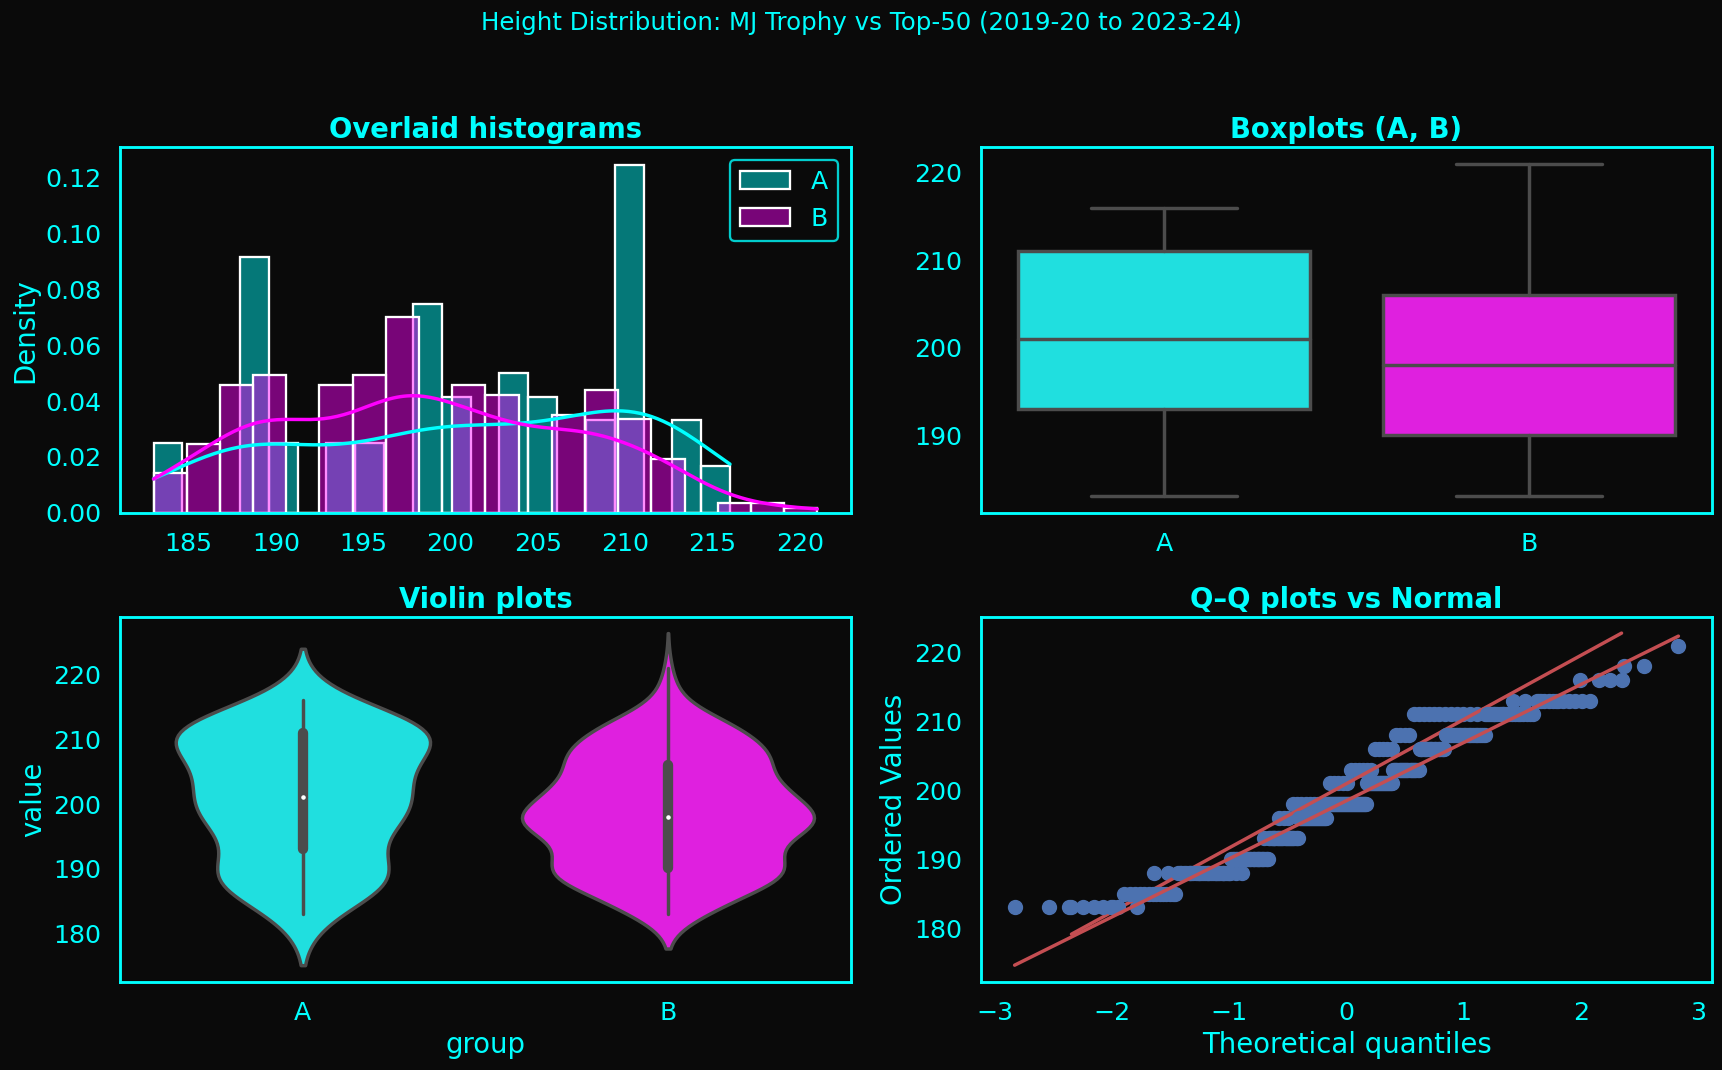

In [ ]:
import glob

mj_files  = sorted(glob.glob(os.path.join(data_path, "csv1_1.csv")))  # MJ Trophy
top_files = sorted(glob.glob(os.path.join(data_path, "csv1_2.csv")))  # Top-50

def load_height_column(file_list, prefer_names=("1","height","Height","HEIGHT","Ht","HT","ht"),
                       fallback_index=2):
    """
    Read HEIGHT from CSVs and return one concatenated numpy array.
    - Try any of prefer_names; otherwise use the 3rd column (index=2).
    - Coerce to numeric and drop NaN.
    """
    out = []
    for fp in file_list:
        df = pd.read_csv(fp)
        col = None
        for name in prefer_names:
            if name in df.columns:
                col = df[name]; break
        if col is None:
            col = df.iloc[:, fallback_index]
        out.append(pd.to_numeric(col, errors="coerce").dropna().astype(float).values)
    return np.concatenate(out, axis=0) if out else np.array([])

#build groups
A = load_height_column(mj_files)     # MJ Trophy heights
B = load_height_column(top_files)    # Top-50 heights
print(f"MJ Trophy n={len(A)} | Top-50 n={len(B)}")

#use your Analyzer class
an = Analyzer()
an.fit(A, B, paired=False)
an.visual_groups(bins=20, kde=True,
                 title="Height Distribution: MJ Trophy vs Top-50 (2019-20 to 2023-24)")

Interpretation :

Central tendency: The MJ Trophy (A) distribution is slightly right-shifted relative to Top-50 (B), i.e., MJ players are a bit taller on average (median A ≈ 200 cm vs. median B ≈ 197–198 cm, eyeballing the plots).

Spread: Box/violin widths are comparable—overall similar variance; B shows slightly heavier tails, especially on the shorter side.

Shape/Normality: Both groups are roughly unimodal and near-normal but not perfectly so:

In the Q–Q plot, mid-quantiles lie close to the line while the tails deviate --> heavier-than-normal tails.

Practical insight: Height seems modestly higher for MJ Trophy players, but the gap isn’t large; Top-50 covers a slightly broader range. To confirm whether this small difference is statistically meaningful, consider a Welch t-test (if normality is acceptable) or Mann–Whitney otherwise.

# 3-1-2 :

# Last two seasons: Champion team (active players) vs Top-15 (same season)

load height & experience

[2023] heights: champion n=18 | top-15 n=15
[2023] experience: champion n=18 | top-15 n=15


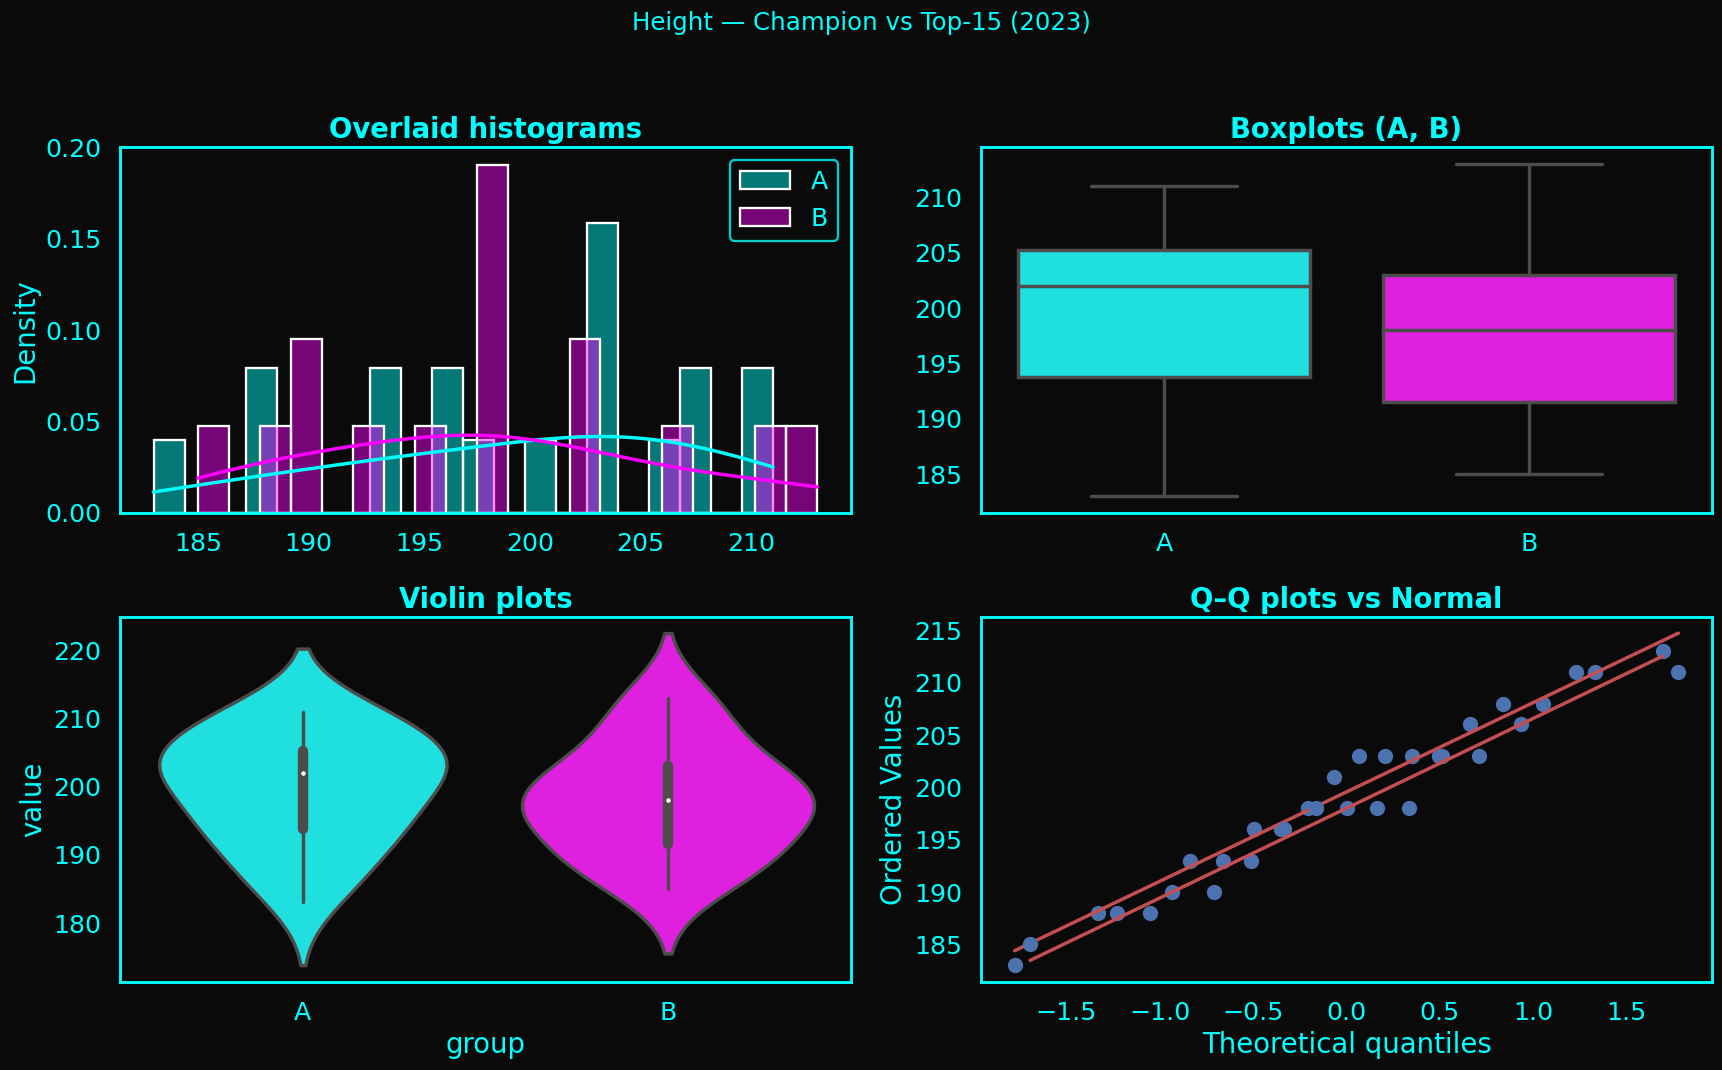

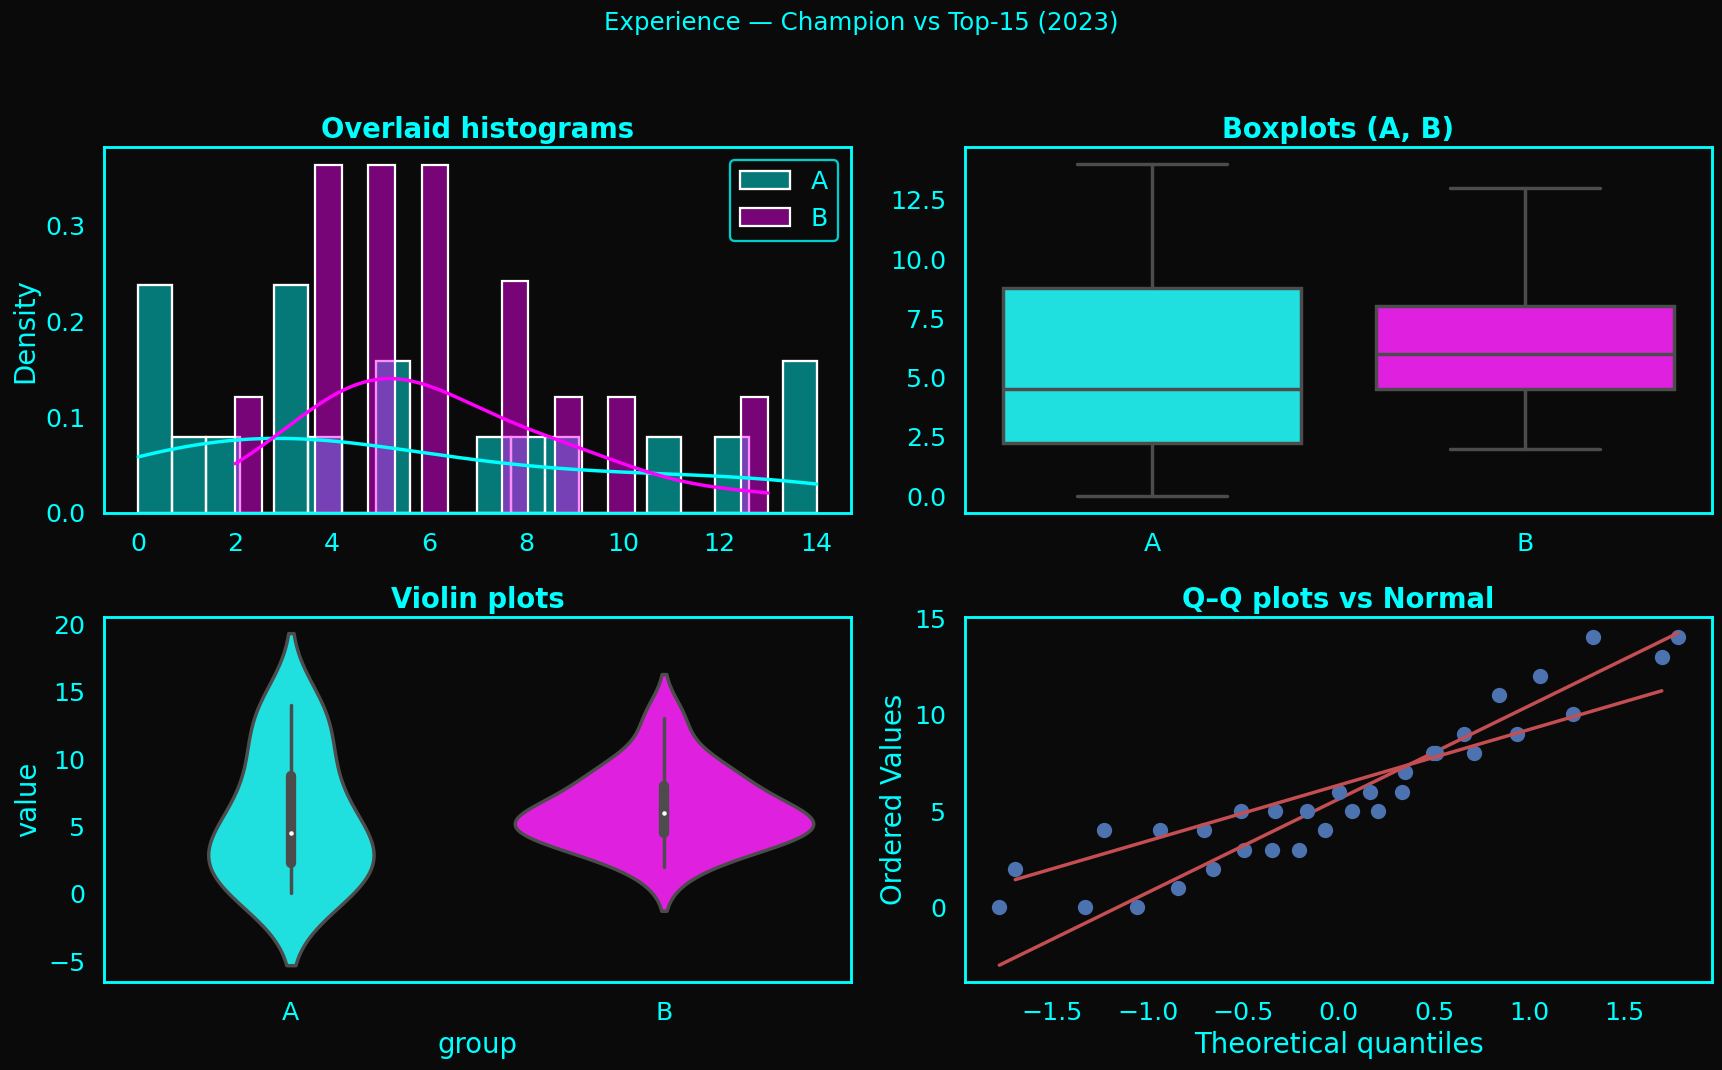

[2024] heights: champion n=19 | top-15 n=15
[2024] experience: champion n=19 | top-15 n=15


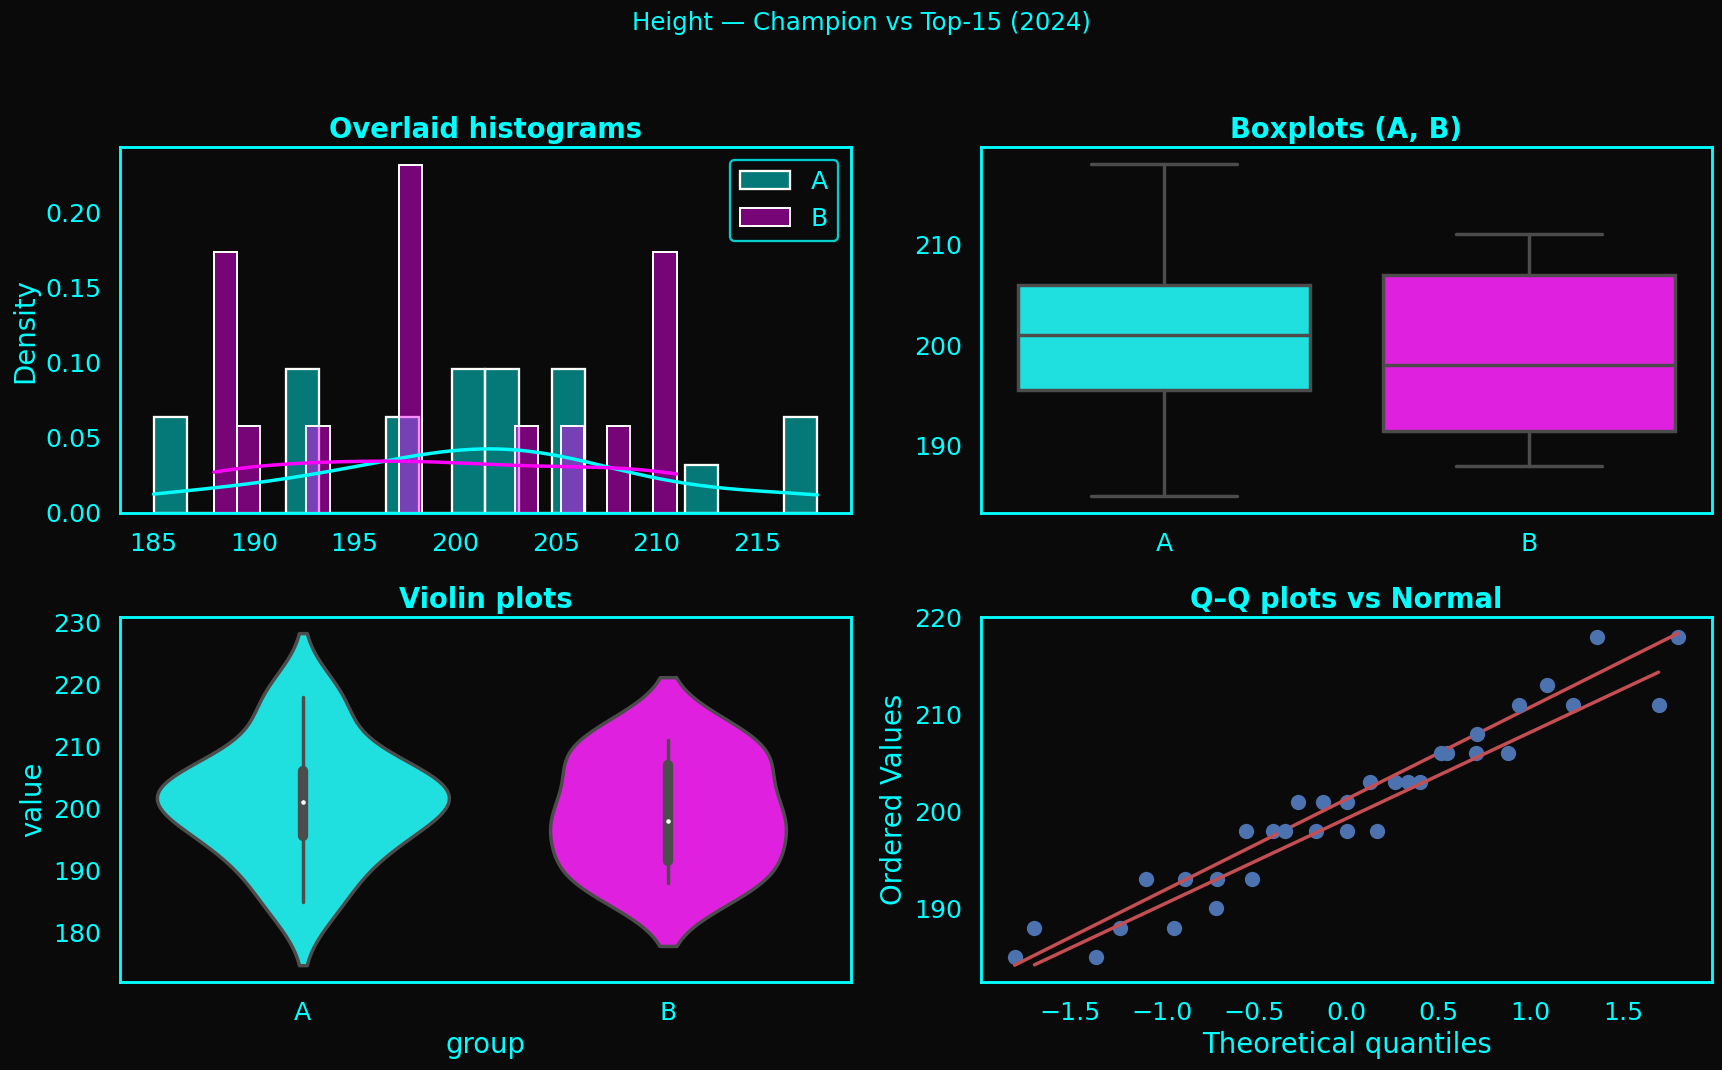

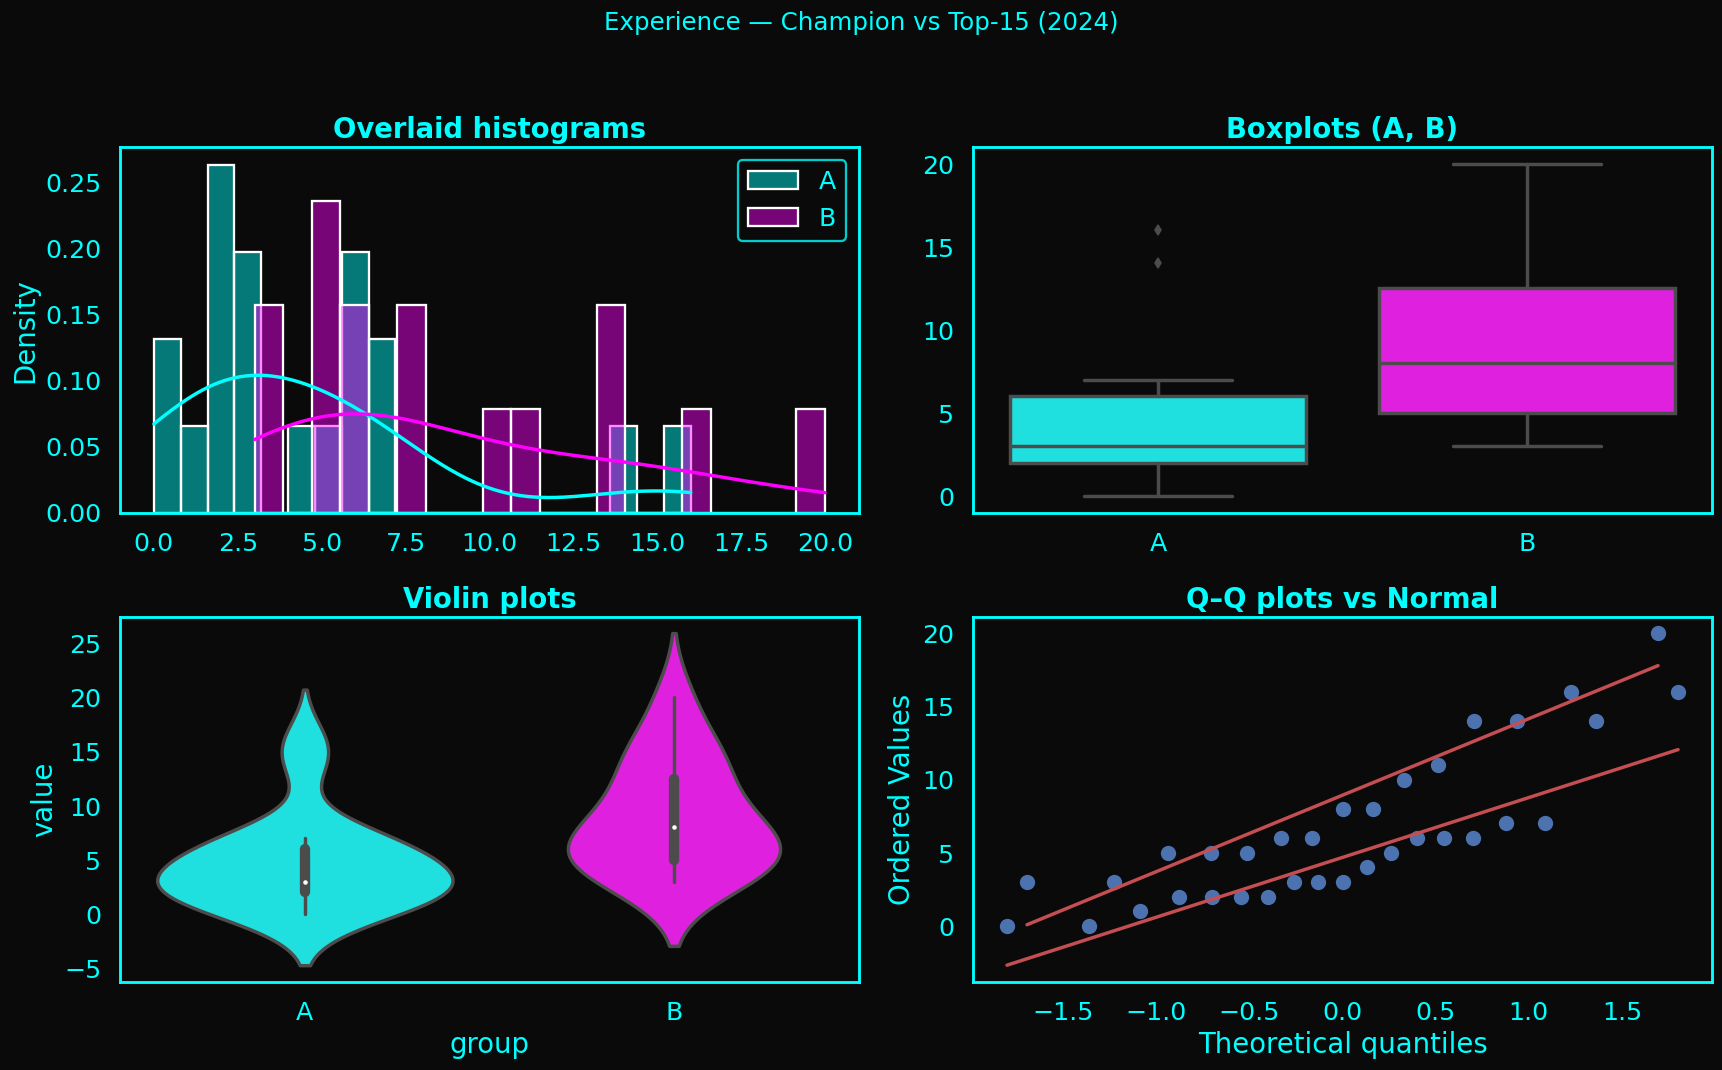

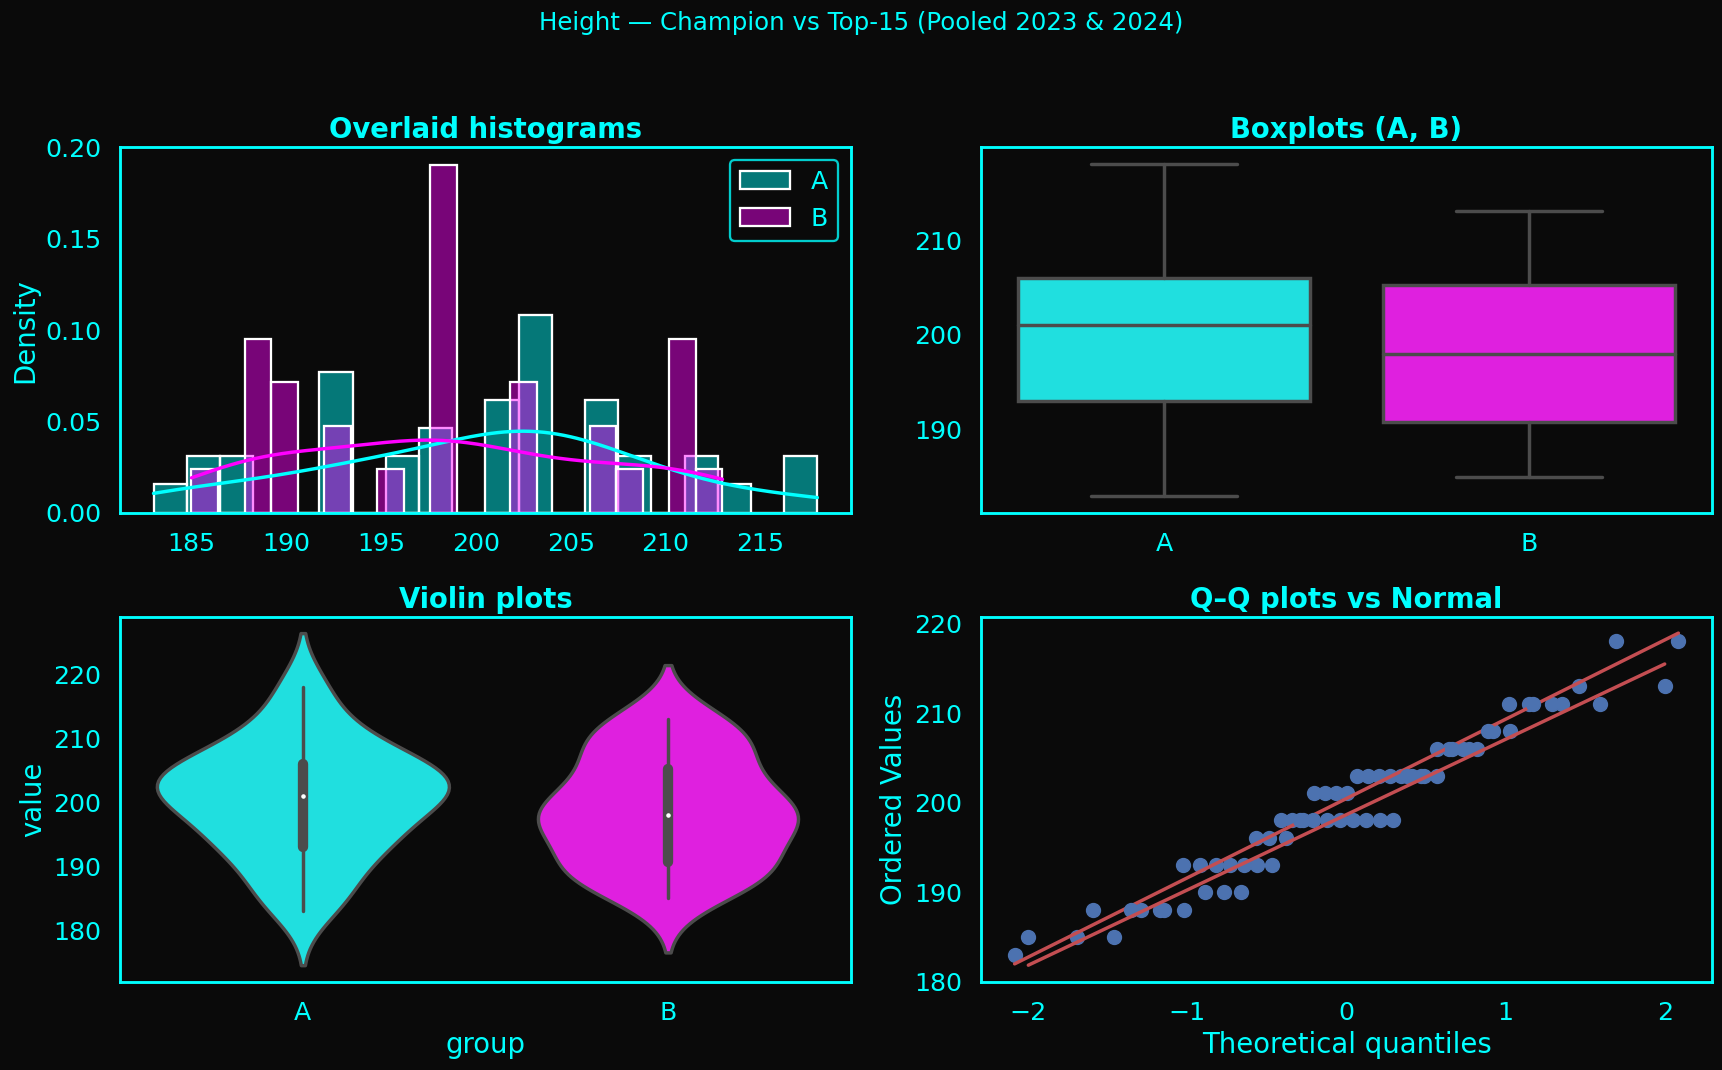

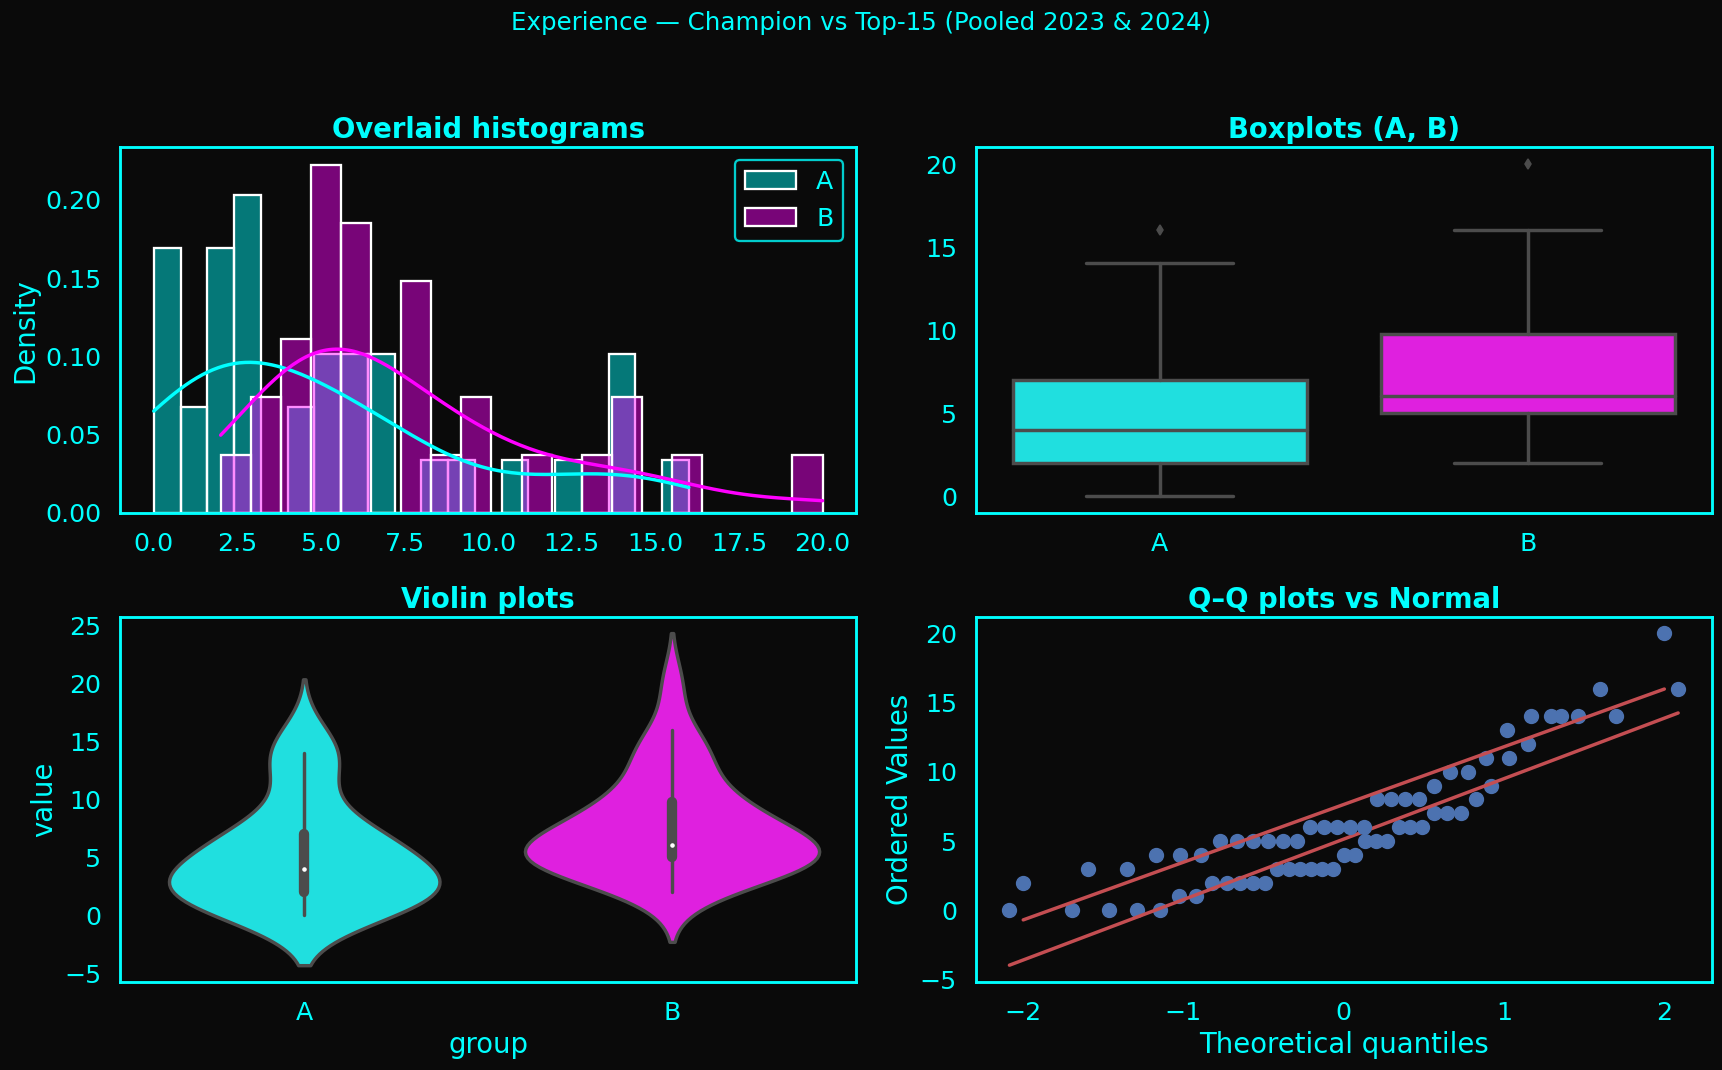

In [ ]:
# unified loader function
def load_columns(df, colnames, fallback_index):
    """
    Load numeric column by name preference, else by index
    """
    col = None
    for name in colnames:
        if name in df.columns:
            col = df[name]; break
    if col is None:
        col = df.iloc[:, fallback_index]
    return pd.to_numeric(col, errors="coerce").dropna().astype(float).values

def get_height(df):
    return load_columns(df, ("height","Height","HEIGHT","Ht","HT","ht"), 2)

def get_experience(df):
    return load_columns(df, ("experience","Experience","EXP","exp","years","Years"), 3)

# load datasets
champ = pd.read_csv(os.path.join(data_path, "csv2_1.csv"))
top15 = pd.read_csv(os.path.join(data_path, "csv2_2.csv"))

# loop over seasons
for season in [2023, 2024]:
    ch_df = champ[champ["season"] == season]
    t15_df = top15[top15["season"] == season]

    H_ch = get_height(ch_df)
    H_t15 = get_height(t15_df)
    E_ch = get_experience(ch_df)
    E_t15 = get_experience(t15_df)

    print(f"[{season}] heights: champion n={len(H_ch)} | top-15 n={len(H_t15)}")
    print(f"[{season}] experience: champion n={len(E_ch)} | top-15 n={len(E_t15)}")

    an = Analyzer()
    an.fit(H_ch, H_t15, paired=False)
    an.visual_groups(bins=20, kde=True, title=f"Height — Champion vs Top-15 ({season})")

    an = Analyzer()
    an.fit(E_ch, E_t15, paired=False)
    an.visual_groups(bins=20, kde=True, title=f"Experience — Champion vs Top-15 ({season})")

# pooled across both seasons
H_ch_all = get_height(champ)
H_t15_all = get_height(top15)
E_ch_all = get_experience(champ)
E_t15_all = get_experience(top15)

an = Analyzer(); an.fit(H_ch_all, H_t15_all, paired=False)
an.visual_groups(bins=20, kde=True, title="Height — Champion vs Top-15 (Pooled 2023 & 2024)")

an = Analyzer(); an.fit(E_ch_all, E_t15_all, paired=False)
an.visual_groups(bins=20, kde=True, title="Experience — Champion vs Top-15 (Pooled 2023 & 2024)")

**Interpretation:**

**Central tendency:** The Champion Team distribution is slightly right-shifted relative to the Top-15 players. Champion players are on average somewhat more experienced, and their mean height is modestly higher, though the experience gap is not large.

**Spread:** Box/violin widths are comparable, indicating similar overall variance. The Top-15 group shows somewhat heavier tails, particularly on the shorter height side, suggesting a wider range.

**Shape/Normality:** Both groups appear roughly unimodal. Height is close to normally distributed; experience is fairly balanced but not strongly distinct across groups.

In the Q–Q plot, mid-quantiles lie near the line, with overall balanced scatter, supporting approximate normality.

**Practical insight:** Champion players have slightly greater experience and are a bit taller on average than the Top-15, but the differences are modest. The Top-15 group spans a broader range. To assess whether these small shifts are statistically meaningful, a Welch t-test (if normality is acceptable) or Mann–Whitney test could be applied.


# 3-1-3 :

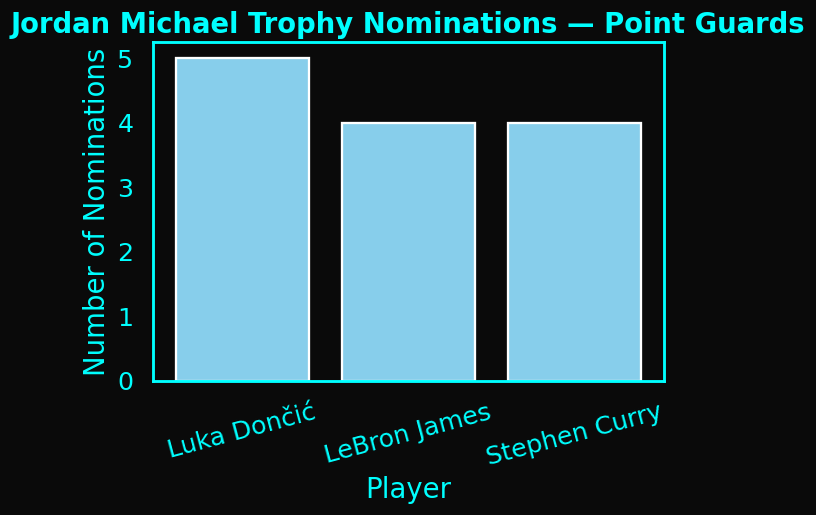

In [ ]:
#3 best
data = {
    "full_name": ["Luka Dončić", "LeBron James", "Stephen Curry"],
    "number_of_nomination": [5, 4, 4]
}
df = pd.DataFrame(data)

# plot bar chart
plt.figure(figsize=(6,4))
plt.bar(df["full_name"], df["number_of_nomination"], color="skyblue")
plt.xlabel("Player")
plt.ylabel("Number of Nominations")
plt.title("Jordan Michael Trophy Nominations — Point Guards")
plt.xticks(rotation=15)
plt.show()

Based on the data, Luka Dončić, LeBron James, and Stephen Curry have the highest number of appearances in the Jordan Michael Trophy list. Therefore, these three players are the best candidates for recruitment in the Point Guard position.

# 3-2-1 :

In [ ]:
from pickle import TRUE
import pandas as pd

agility_s2324 = pd.read_csv(os.path.join(data_path, "csv_h1_1.csv"))
agility_s2122 = pd.read_csv(os.path.join(data_path, "csv_h1_2.csv"))

test_obj = Analyzer()
test_obj.fit(agility_s2324["agility"], agility_s2122["agility"])
test_obj.analysis_starter()
test_obj.run_test()

{'test_used': 'Independent t-test (equal var)',
 'alpha': 0.05,
 'n_a': 40,
 'n_b': 40,
 'statistic': 0.03278580009701344,
 'p_value': 0.9739291542122088,
 'significant': False,
 'effect_size': 0.007331127771364125}

The hypothesis in this question was that players’ agility has increased compared to the past. Based on the calculated height-to-weight ratio, this claim was rejected. Therefore, we cannot confirm the hypothesis.


# 3-2-2

In [ ]:
potential_s2324 = pd.read_csv(os.path.join(data_path, "csv_h2_1.csv"))
potential_s2122 = pd.read_csv(os.path.join(data_path, "csv_h2_2.csv"))

test_obj = Analyzer()
test_obj.fit(potential_s2324["potential"], potential_s2122["potential"])
test_obj.analysis_starter()
test_obj.run_test()

{'test_used': 'Mann-Whitney U Test',
 'alpha': 0.05,
 'n_a': 37,
 'n_b': 39,
 'statistic': 755.0,
 'p_value': 0.7310674720727703,
 'significant': False,
 'effect_size': -0.04643104643104645}

An expert claimed that, due to advancements and improved conditions, the use and development of individuals’ innate abilities have increased compared to the past. For example, it was argued that the average innate ability of the champion team players in the last two seasons was higher than in the two seasons b
